# Noise 이미지를 구분해 보자
- MNIST 학습 모델에 Fashion MNIST 이미지를 넣으면 잘 구분할까?
- 여기서는 CNN, Transfer Learning 사용
- 최종 모델은 입력 1개, 출력 2개 나옴

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np

In [2]:
layer = keras.layers
print("tensorflow version check : ", tf.__version__)
print("gpu check", tf.test.is_gpu_available())


tensorflow version check :  2.4.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
gpu check True


## 1. MNIST dataset 메모리에 올리기

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("mnist dataset on memory")
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print("The shape of train dataset : ", x_train.shape)
print("The shape of test dataset : ", x_test.shape)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(5000).batch(32)

11493376/11490434 [==============================] - 0s 0us/step
mnist dataset on memory
The shape of train dataset :  (60000, 28, 28, 1)
The shape of test dataset :  (10000, 28, 28, 1)


## 2. model 만들기

In [4]:
inputs = keras.Input(shape=(28, 28, 1))
feature = layer.Conv2D(32, 3,activation='relu')(inputs)
feature = layer.MaxPool2D(pool_size=(2, 2))(feature)
feature = layer.Conv2D(64, 3, activation='relu')(feature)
feature = layer.MaxPool2D(pool_size=(2, 2))(feature)
flatten = layer.Flatten()(feature)
dense_layer = layer.Dense(128, activation='relu')(flatten)
prob = layer.Dense(10, activation='softmax')(dense_layer)
model = keras.Model(inputs, prob)

In [5]:
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928

In [6]:
print('========================Training===============================')

model.fit(x_train, y_train, epochs=5)

print('========================Evaluation===============================')

test_loss, test_acc = model.evaluate(test_ds)

# del model
# keras.backend.clear_session()

========================Training===============================
Epoch 1/5
1875/1875 [==============================] - 38s 3ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.9167
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0444 - sparse_categorical_accuracy: 0.9858
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9908
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9930
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9943
========================Evaluation===============================
313/313 [==============================] - 1s 2ms/step - loss: 0.0317 - sparse_categorical_accuracy: 0.9902


## 3. Noise 이미지 문제
- 손글씨 학습 모델에 Fashion MNIST 이미지를 입력으로 넣으면 어떻게 될까?

In [7]:
[fashine_train_x, fashine_train_y], [fashine_test_x, fashine_test_y] = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [8]:
tmp_data = fashine_train_x[1]/255.0

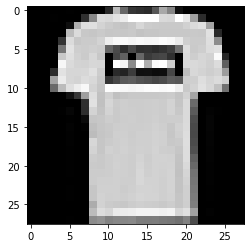

In [9]:
from matplotlib import pyplot as plt

plt.imshow(tmp_data, cmap='gray')

In [10]:
# 모델의 Softmax 통해서 각 class에 대한 확률값을 알수 있다. 글자 8 예측
# 하지만, 손글씨 모델에 티셧츠 넣으면 제대로 분류한 걸까?

tmp_data = tf.reshape(tmp_data, [1, 28, 28, 1])
model.predict(tmp_data)

array([[1.5221938e-05, 1.3675982e-05, 4.6590334e-03, 4.8756031e-03,
        1.8241903e-05, 2.3117773e-03, 5.8336218e-04, 5.7599121e-03,
        9.8162454e-01, 1.3868455e-04]], dtype=float32)

## 4. Noise 이미지를 구분해 보는 모델을 만들자

In [11]:
# 모델 레이어 수정
# 아웃풋 레이어의 activation은 None으로 해주고, softmax를 따로 만들어줍니다.
# 그 이유는 선형분류기가 출력하는 score의 부호를 검사해서, 학습되지 않은 클래스의 이미지는 걸러주기 위해서에요.

inputs = keras.Input(shape=(28, 28, 1))
feature = layer.Conv2D(32, 3,activation='relu')(inputs)
feature = layer.MaxPool2D(pool_size=(2, 2))(feature)
feature = layer.Conv2D(64, 3, activation='relu')(feature)
feature = layer.MaxPool2D(pool_size=(2, 2))(feature)
flatten = layer.Flatten()(feature)
dense_layer = layer.Dense(128, activation='relu')(flatten)
scores = layer.Dense(10, activation=None)(dense_layer)
prob = tf.keras.activations.softmax(scores)
model = keras.Model(inputs, prob)

In [12]:
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2049

In [13]:
print('========================Training===============================')

model.fit(x_train, y_train, epochs=5)

print('========================Evaluation===============================')

test_loss, test_acc = model.evaluate(test_ds)

# del model
# keras.backend.clear_session()

========================Training===============================
Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2762 - sparse_categorical_accuracy: 0.9136
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9863
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9914
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0230 - sparse_categorical_accuracy: 0.9935
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0175 - sparse_categorical_accuracy: 0.9950
========================Evaluation===============================
313/313 [==============================] - 1s 2ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9902


## 5. 위의 만들 모델에 대해 Transfer Learning 사용해 보자

In [14]:
# 입력은 input_2 1개 , 출력은 dense_2, tf.compat.v1.nn.softmax 2개 나오게 모델 구성
# Transfer Learning

test_model = tf.keras.Model(inputs=model.get_layer('input_2').input, 
                            outputs=[model.get_layer('dense_3').output, 
                                     model.get_layer('tf.compat.v1.nn.softmax').output])

## 6. fashine mnist를 넣어 테스트를 해보면 
## score 값이 모두 큰 음수가 나오는 것을 확인할 수 있어요!

In [15]:
test_model.predict(tmp_data)

[array([[-12.181588 , -12.95783  ,  -8.592701 , -10.792038 , -13.046747 ,
         -11.370833 , -10.052972 ,  -7.356374 ,  -6.1990557, -12.561208 ]],
       dtype=float32),
 array([[0.0017407 , 0.00080095, 0.06300255, 0.00698551, 0.00073281,
         0.00391589, 0.01462751, 0.21691431, 0.6900889 , 0.00119085]],
       dtype=float32)]

## 7. 학습시켰던 클래스를 가지고 있는 mnist 영상에 대해서는 어떨까요?
## 해당 클래스의 스코어 값은 양수로 표현됩니다.

In [16]:
tmp_data = x_test[0]

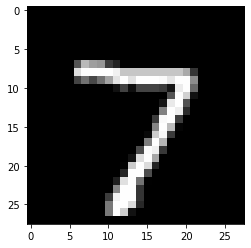

In [17]:
plt.imshow(  tmp_data[:,:,0], cmap='gray')

In [18]:
test_model.predict(np.reshape(tmp_data, [1, 28, 28, 1]))

[array([[-18.763884, -22.010052, -12.802172, -15.575059, -24.117012,
         -21.91586 , -33.405346,   4.591707, -19.300499, -12.672052]],
       dtype=float32),
 array([[7.1911081e-11, 2.7989997e-12, 2.7921217e-08, 1.7445536e-09,
         3.4037814e-13, 3.0754605e-12, 3.1483910e-17, 1.0000000e+00,
         4.2048129e-11, 3.1801271e-08]], dtype=float32)]